In [1]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import control as ct
import scienceplots

#Exibição dos gráficos em janela externa:
#%matplotlib qt

# Configurações de plot:
plt.style.use([
    'grid',
    'retro'
])
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size'] = 20 
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
#Parâmetros conhecidos do sistema:
vt = 12 #tensão nominal nos terminais
Rs = 1  #resistência de shunt 

In [3]:
#Função para implementação de um filtro passa-baixas digital de butterworth:
def LPF(y, order,  wn, fs):
    b, a = scipy.signal.iirfilter(order, Wn=wn, fs=fs, btype='low', ftype='butter')
    return scipy.signal.filtfilt(b, a, y)

#Função para encontrar o índice de um elemento num array (aproximação):
def index(array, value):
    return np.abs(array-value).argmin()

In [4]:
# Abertura dos arquivos de dados:
motpts = np.loadtxt('pontos-motor.txt')     #tensao  corrente   velocidade
syspts = np.loadtxt('pontos-sistema.txt')   #tensao  ângulo
syspts2 = np.loadtxt('pontos-sistema2.txt')   #tensao  ângulo
osc = np.loadtxt('oscs\osc1.txt')            #tempo  angulo  ref usig
calib = np.loadtxt('calib.txt')            #tempo  angulo  ref usig

In [5]:
osc = [(osc[:, 0]-osc[0][0]), osc[:, 1], osc[:, 2], osc[:, 3]]
motpts = [motpts[:, 0], motpts[:, 1], motpts[:, 2]]
syspts = [syspts[:, 0], syspts[:, 1]]
syspts2 = [syspts2[:, 0], syspts2[:, 1]]
calib = [(calib[:, 0]-calib[0][0]), calib[:, 1], calib[:, 2], calib[:, 3]]

### $$ \text{Ensaio de rotor bloqueado (tensão nominal):}$$

Ra = 12.0545297501935
tau_e = 0.000724
La = 0.008727479539140095


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


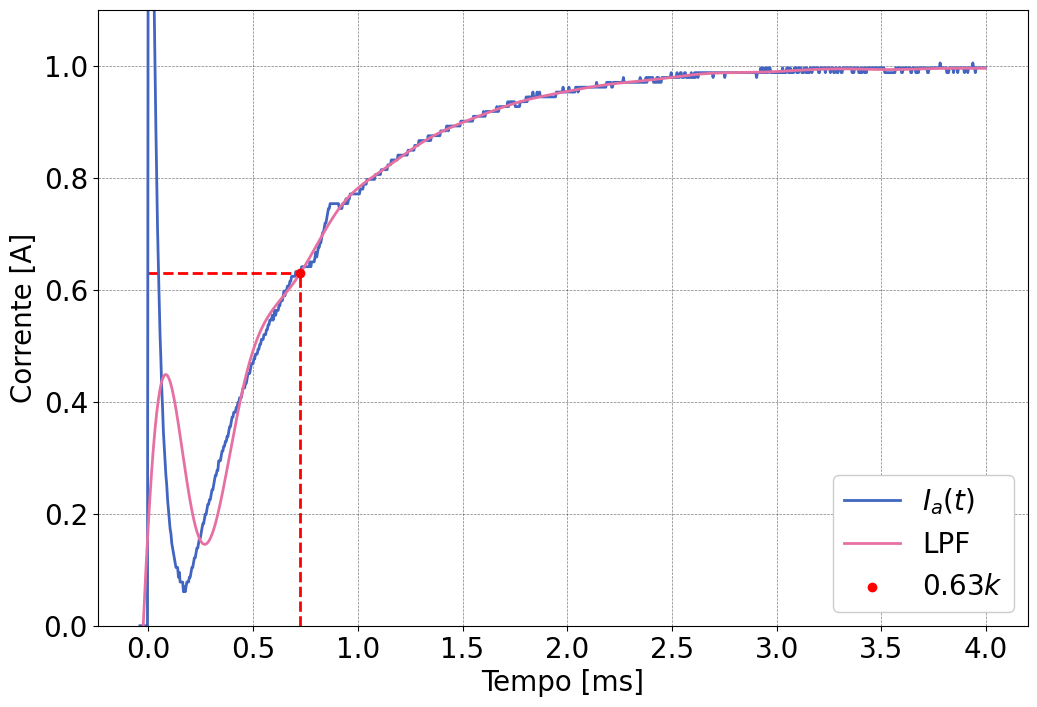

In [6]:
#Carregando curva do osciloscópio:
RB = np.loadtxt('RB\F0002CH1.csv', delimiter=',', unpack=True, dtype='str')
t1 = RB[3].astype(np.float_)[1240:2250]
y1 = RB[4].astype(np.float_)[1240:2250]
y1lpf = LPF(y1, 4, 10, 1e3)

#Cálculo da resistência de armadura:
Ra = (((vt/y1lpf[-1])-1)*Rs)
print(f'Ra = {Ra}')

#Ajuste da corrente pela queda de tensão no shunt:
y1 *= ((1/Ra)+(1/Rs))
y1lpf = LPF(y1, 4, 10, 1e3)

#Cálculo da constante de tempo elétrica:
y163 = 0.632*y1lpf[-1]
taue = t1[index(y1lpf[50:], y163)+50]
print(f'tau_e = {taue}')

#Cálculo da indutância de armadura:
La = taue*Ra
print(f'La = {La}')

#Plot dos dados:
plt.figure()
plt.plot((0, taue*1e3), (y163, y163), linestyle='dashed', color='r', zorder=0)
plt.plot((taue*1e3, taue*1e3), (0, y163), linestyle='dashed', color='r', zorder=0)
plt.plot(t1*1e3, y1, label='$I_a(t)$', zorder=1)
plt.plot(t1*1e3, y1lpf, label='LPF', zorder=2)
plt.scatter(taue*1e3, y163, color='r', label='$0.63k$', zorder=3)
plt.ylim(0, 1.1)
plt.ylabel('Corrente [A]')
plt.xlabel('Tempo [ms]')
plt.legend()
plt.savefig('curves/rb.eps', dpi=600, transparent=True, bbox_inches='tight')

### $$ \text{Ensaio a vazio (tensão nominal):}$$

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


tau_m = 0.3679999999999999


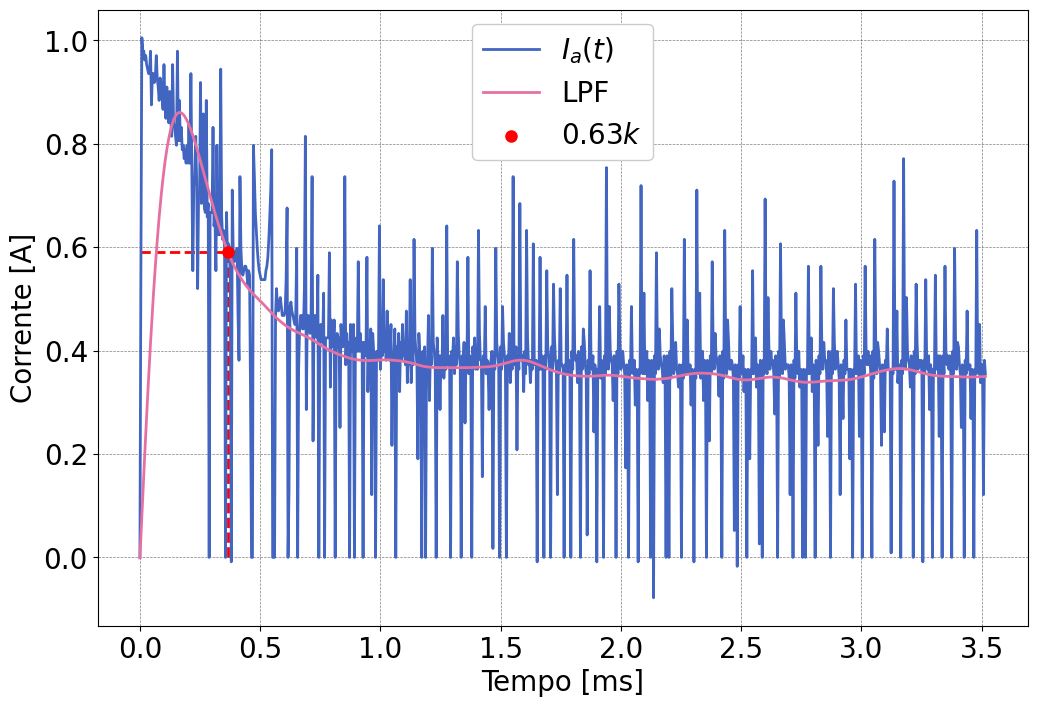

In [7]:
#Carregando curva do osciloscópio:
VZ = np.loadtxt('VZ\F0000CH1.csv', delimiter=',', unpack=True, dtype='str')
t2 = VZ[3].astype(np.float_)[320:1200]-VZ[3].astype(np.float_)[320]
y2 = VZ[4].astype(np.float_)[320:1200]
y2lpf = LPF(y2, 2, 10, 10e2)

#Ajuste da corrente pela queda de tensão no shunt:
y2 *= ((1/Ra)+(1/Rs))
y2lpf = LPF(y2, 2, 10, 10e2)

#Cálculo da constante de tempo mecânica:
y263 = (y2[2]-(0.632*(y2[2]-y2lpf[-1])))
taum = t2[index(y2lpf[30:], y263)+30]
print(f'tau_m = {taum}')

#Plot dos dados:
plt.figure()
plt.plot((0, taum), (y263, y263), linestyle='dashed', color='r', zorder=0)
plt.plot((taum, taum), (0, y263), linestyle='dashed', color='r', zorder=0)
plt.plot(t2, y2, label='$I_a(t)$', zorder=1)
plt.plot(t2, y2lpf, label='LPF', zorder=2)
plt.scatter(taum, y263, linewidths=3, color='r', label='$0.63k$', zorder=3)
#plt.ylim(0, 1.1)
plt.ylabel('Corrente [A]')
plt.xlabel('Tempo [ms]')
plt.legend()
plt.savefig('curves/vz.eps', dpi=600, transparent=True, bbox_inches='tight')

### $$ \text{Conferindo linearidade do motor:}$$

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


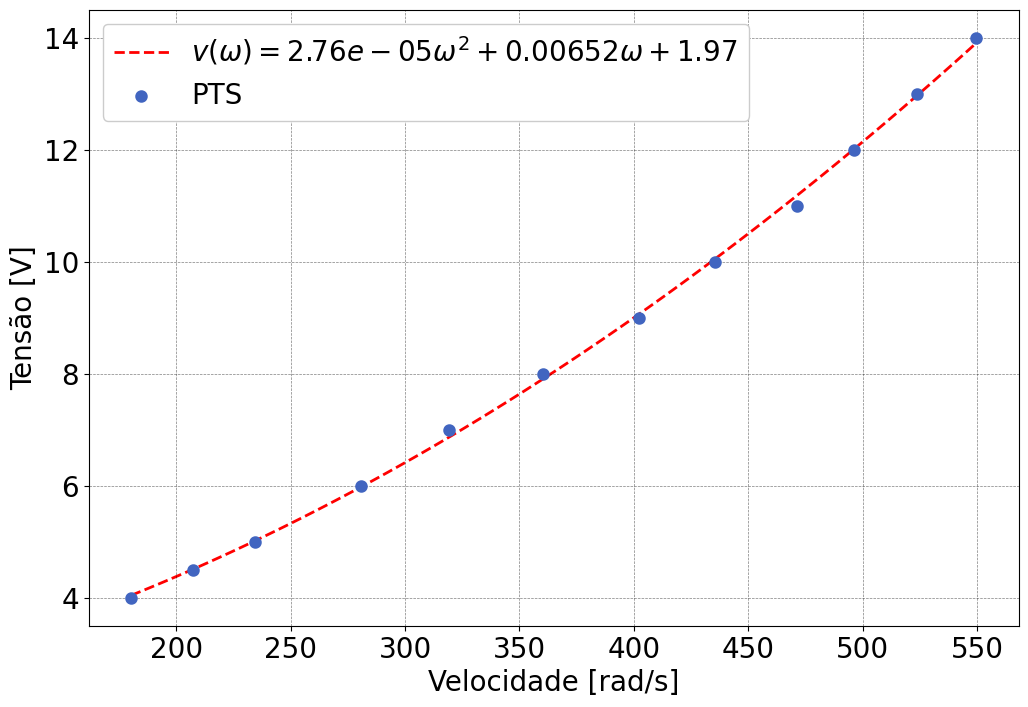

In [8]:
#Ajuste dos dados:
vmot = motpts[0][2:]
nmot = (motpts[2][2:]*2*np.pi/60)
nreg = np.linspace(nmot[0], nmot[-1], 100)
pol = np.polyfit(nmot, vmot, 2)
vreg = np.polyval(pol, nreg)

#Plot:
plt.figure()
plt.plot(nreg, vreg, linestyle='dashed', color='r', zorder=0, label=f'$v(\omega) = {round(pol[0],7)}\omega^2 + {round(pol[1],5)}\omega + {round(pol[2],2)}$')
plt.scatter(nmot, vmot, linewidth=3, zorder=1, label='PTS')
plt.ylabel('Tensão [V]')
plt.xlabel('Velocidade [rad/s]')
plt.legend()
plt.savefig('curves/motwxv1.eps', dpi=600, transparent=True, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


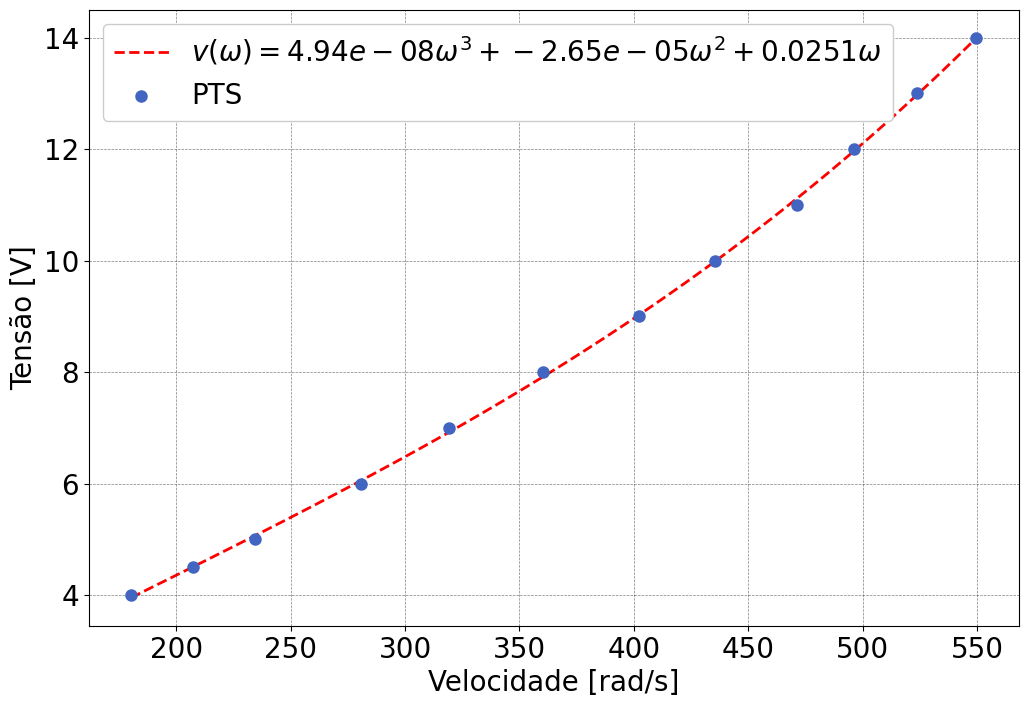

In [9]:
#Ajuste cúbico sem termo independente:
A = []
for w in nmot:
    A.append([w, w**2, w**3])
A = np.array(A)
B = np.array(vmot)[:, np.newaxis]
C = (np.linalg.inv(A.T@A)@A.T@B).T[0]

c1 = C[0]
c2 = C[1]
c3 = C[2]

#Ajuste dos dados:
vadj = np.polyval(np.array([c3, c2, c1, 0]), nreg)

#Plot:
plt.figure()
plt.plot(nreg, vadj, linestyle='dashed', color='r', zorder=0, label=f'$v(\omega) = {round(c3,10)}\omega^3 + {round(c2,7)}\omega^2 + {round(c1,4)}\omega$')
plt.scatter(nmot, vmot,  linewidth=3, zorder=1, label='PTS')
plt.ylabel('Tensão [V]')
plt.xlabel('Velocidade [rad/s]')
plt.legend()
plt.savefig('curves/motwxv2.eps', dpi=600, transparent=True, bbox_inches='tight')

In [10]:
#Cálulo da força contra-eletromotriz (para tensão nominal e a vazio):
vb = vt-Ra*y2lpf[-1]
print(f'Vb = {vb}')

#Cálculo da constante magnética e construtiva do motor (ponto de velocidade e tensão nominais):
kaphi = (vb/(4740*2*np.pi/60))
print(f'kaphi = {kaphi}')

#Cálculo da perda por ventilação e atrito no motor:
#Bm = ((kaphi*y2lpf[-1])/(4740*2*np.pi/60))
b1 = (((c1*kaphi)-(kaphi**2))/Ra)
b2 = (c2*kaphi/Ra)
b3 = (c3*kaphi/Ra)
#print(f'Bm = {Bm}')
print(f'b1 = {b1} \t b2 = {b2} \t b3 = {b3}')

#Cálculo do momento de inércia do motor:
Jm = taum*(b1+((kaphi**2)/Ra))
print(f'Jm = {Jm}')

Vb = 7.784515929495702
kaphi = 0.015682837845023306
b1 = 1.2293702034896656e-05 	 b2 = -3.454008805802967e-08 	 b3 = 6.423377992452236e-11
Jm = 1.203247281558081e-05


### $$ \text{Oscilação livre da placa:}$$

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


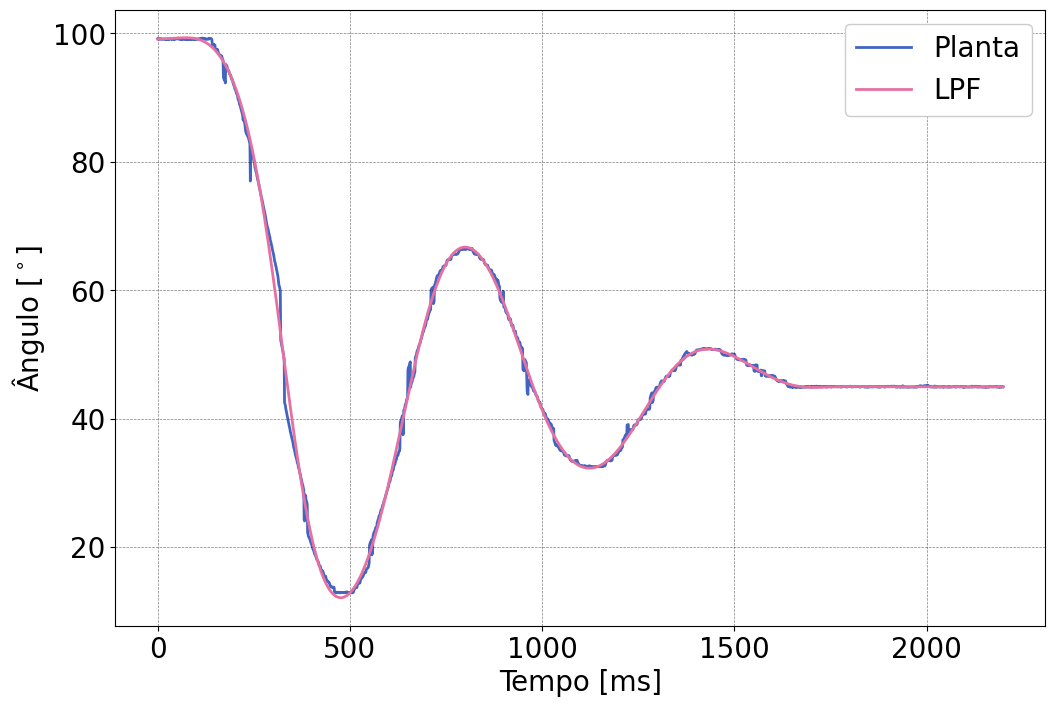

In [11]:
#Decupagem:
tosc = osc[0][800:3000]-osc[0][800]
angosc = osc[1][800:3000]

plt.figure()
plt.plot(tosc*1e3, angosc, label='Planta', zorder=0)
plt.plot(tosc*1e3, LPF(angosc, 4, 5, 1e3), label='LPF', zorder=1)
plt.ylabel('Ângulo [$^\circ$]')
plt.xlabel('Tempo [ms]')
plt.legend()
plt.savefig('curves/freeosc.eps', dpi=600, transparent=True, bbox_inches='tight')

### $$ \text{Conferindo linearidade do sistema completo:}$$

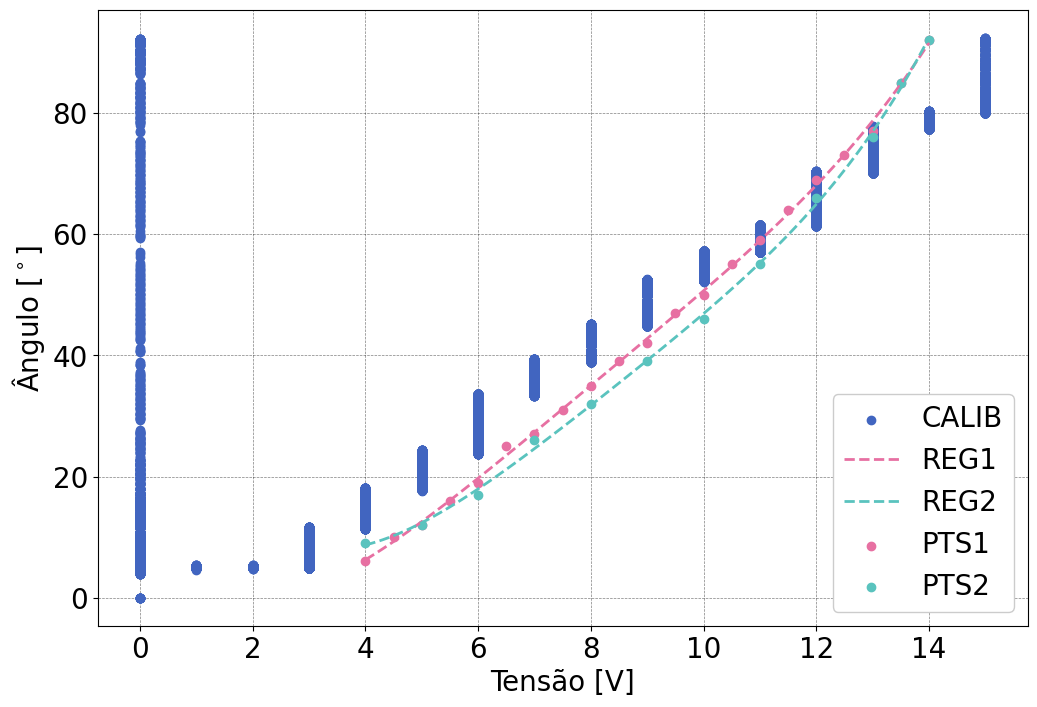

In [12]:
#Ajuste dos dados:
vin = syspts[0]
ang = syspts[1]
vreg = np.linspace(vin[0], vin[-1], 100)
angreg1 = np.polyval(np.polyfit(vin, ang, 4), vreg)
angreg2 = np.polyval(np.polyfit(syspts2[0], syspts2[1], 4), vreg)

#Plot:
plt.figure()
plt.scatter((calib[3]/100)*20, calib[1], color='C0', label='CALIB')
plt.plot(vreg, angreg1, linestyle='dashed', color='C1', label='REG1')
plt.plot(vreg, angreg2, linestyle='dashed', color='C2', label='REG2')
plt.scatter(vin, ang, color='C1', label='PTS1')
plt.scatter(syspts2[0], syspts2[1], color='C2', label='PTS2')
plt.ylabel('Ângulo [$^\circ$]')
plt.xlabel('Tensão [V]')
plt.legend()
plt.show()